## Проект e-commerce
Итоги 

1. Сколько у нас пользователей, которые совершили покупку только один раз? (7 баллов) 

Для начала нужно определить, что должно считаться покупкой. 

Критерии покупки: 
 
∙ Заказ является оплаченным, статус заказа != "created", "invoiced" 
∙ Заказ не отменен, статус заказа != canceled
∙ Статус заказа != "unavailable"

91,804 пользователя купили 1 раз. 

2. Сколько заказов в месяц в среднем не доставляется по разным причинам (вывести детализацию по причинам)? (5 баллов)

См. ниже. 

3. По каждому товару определить, в какой день недели товар чаще всего покупается. (5 баллов)

См. ниже. 

4. Сколько у каждого из пользователей в среднем покупок в неделю (по месяцам)? Не стоит забывать, что внутри месяца может быть не целое количество недель. Например, в ноябре 2021 года 4,28 недели. И внутри метрики это нужно учесть. (8 баллов) 

См. ниже. 

5. Используя pandas, проведи когортный анализ пользователей. В период с января по декабрь выяви когорту с самым высоким retention на 3й месяц. Описание подхода можно найти тут. (10 баллов)

Самый высокий RR 3-го месяца наблюдается в когорте 2017-05. 

6. Часто для качественного анализа аудитории использую подходы, основанные на сегментации. Используя python, построй RFM-сегментацию пользователей, чтобы качественно оценить свою аудиторию. В кластеризации можешь выбрать следующие метрики: R - время от последней покупки пользователя до текущей даты, F - суммарное количество покупок у пользователя за всё время, M - сумма покупок за всё время. Подробно опиши, как ты создавал кластеры. Для каждого RFM-сегмента построй границы метрик recency, frequency и monetary для интерпретации этих кластеров. Пример такого описания: RFM-сегмент 132 (recency=1, frequency=3, monetary=2) имеет границы метрик recency от 130 до 500 дней, frequency от 2 до 5 заказов в неделю, monetary от 1780 до 3560 рублей в неделю. Описание подхода можно найти тут. (35 баллов)

См. ниже. 


In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import plotly.express as px
from datetime import datetime as dt
from statistics import mean
import warnings
from operator import attrgetter
import matplotlib.colors as mcolors
%matplotlib inline 

In [2]:
users = pd.read_csv('/mnt/HC_Volume_18315164/home-jupyter/jupyter-n-baryshnikov-24/olist_customers_dataset.csv', encoding = 'windows-1251')
items = pd.read_csv('/mnt/HC_Volume_18315164/home-jupyter/jupyter-n-baryshnikov-24/olist_order_items_dataset.csv', encoding = 'windows-1251')
orders = pd.read_csv('/mnt/HC_Volume_18315164/home-jupyter/jupyter-n-baryshnikov-24/olist_orders_dataset.csv', encoding = 'windows-1251')

## 1. Предобработка данных 
Проверка форматов 

In [3]:
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99441 entries, 0 to 99440
Data columns (total 5 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   customer_id               99441 non-null  object
 1   customer_unique_id        99441 non-null  object
 2   customer_zip_code_prefix  99441 non-null  int64 
 3   customer_city             99441 non-null  object
 4   customer_state            99441 non-null  object
dtypes: int64(1), object(4)
memory usage: 3.8+ MB


In [4]:
# items.head()
items.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 112650 entries, 0 to 112649
Data columns (total 7 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   order_id             112650 non-null  object 
 1   order_item_id        112650 non-null  int64  
 2   product_id           112650 non-null  object 
 3   seller_id            112650 non-null  object 
 4   shipping_limit_date  112650 non-null  object 
 5   price                112650 non-null  float64
 6   freight_value        112650 non-null  float64
dtypes: float64(2), int64(1), object(4)
memory usage: 6.0+ MB


In [5]:
orders.info() # из данных видно, что формат колонок не соответсвует логике данных, необходимо изменить формат для даты 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99441 entries, 0 to 99440
Data columns (total 8 columns):
 #   Column                         Non-Null Count  Dtype 
---  ------                         --------------  ----- 
 0   order_id                       99441 non-null  object
 1   customer_id                    99441 non-null  object
 2   order_status                   99441 non-null  object
 3   order_purchase_timestamp       99441 non-null  object
 4   order_approved_at              99281 non-null  object
 5   order_delivered_carrier_date   97658 non-null  object
 6   order_delivered_customer_date  96476 non-null  object
 7   order_estimated_delivery_date  99441 non-null  object
dtypes: object(8)
memory usage: 6.1+ MB


Изменим форматы на корректные, для дат: 

In [3]:
orders[['order_purchase_timestamp', 'order_approved_at', 'order_delivered_carrier_date', 'order_delivered_customer_date', 'order_estimated_delivery_date']] = orders[['order_purchase_timestamp', 'order_approved_at', 'order_delivered_carrier_date', 'order_delivered_customer_date', 'order_estimated_delivery_date']].apply(pd.to_datetime, errors='coerce')
items['shipping_limit_date'] = items['shipping_limit_date'].apply(pd.to_datetime, errors='coerce')

In [258]:
items.info() #checked 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 112650 entries, 0 to 112649
Data columns (total 7 columns):
 #   Column               Non-Null Count   Dtype         
---  ------               --------------   -----         
 0   order_id             112650 non-null  object        
 1   order_item_id        112650 non-null  int64         
 2   product_id           112650 non-null  object        
 3   seller_id            112650 non-null  object        
 4   shipping_limit_date  112650 non-null  datetime64[ns]
 5   price                112650 non-null  float64       
 6   freight_value        112650 non-null  float64       
dtypes: datetime64[ns](1), float64(2), int64(1), object(3)
memory usage: 6.0+ MB


## Проверка на пропущенные значения 

In [260]:
users.isna().sum()

customer_id                 0
customer_unique_id          0
customer_zip_code_prefix    0
customer_city               0
customer_state              0
dtype: int64

In [9]:
orders.isna().sum() # есть пропуски

order_id                            0
customer_id                         0
order_status                        0
order_purchase_timestamp            0
order_approved_at                 160
order_delivered_carrier_date     1783
order_delivered_customer_date    2965
order_estimated_delivery_date       0
dtype: int64

In [11]:
items.isna().sum()

order_id               0
order_item_id          0
product_id             0
seller_id              0
shipping_limit_date    0
price                  0
freight_value          0
dtype: int64

## 1. Сколько у нас пользователей, которые совершили покупку только один раз? (7 баллов)

In [12]:
users.head(2)

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,9790,sao bernardo do campo,SP


In [13]:
orders.head(2)

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13


In [14]:
items.head(2)

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:35,58.9,13.29
1,00018f77f2f0320c557190d7a144bdd3,1,e5f2d52b802189ee658865ca93d83a8f,dd7ddc04e1b6c2c614352b383efe2d36,2017-05-03 11:05:13,239.9,19.93


In [ ]:
# Для начала нужно определить, что должно считаться покупкой. 

# Критерии покупки: 
 
# ∙ Заказ является оплаченным, статус заказа != "created", "invoiced" 
# ∙ Заказ не отменен, статус заказа != canceled
# ∙ Статус заказа != "unavailable"

In [4]:
p_orders = orders.query('order_status not in ["canceled", "created", "invoiced", "unavailable"] and order_approved_at != "NaN"')
users_orders = users.merge(p_orders, how='left', on=['customer_id', 'customer_id'])
users_orders.groupby('order_status').agg({'customer_unique_id':'count'})

,customer_unique_id
order_status,
approved,2
delivered,96464
processing,301
shipped,1107


In [5]:
users_orders.groupby('customer_unique_id', as_index = False).agg({'order_id':'count'}).query('order_id == 1').head()

,customer_unique_id,order_id
0,0000366f3b9a7992bf8c76cfdf3221e2,1
1,0000b849f77a49e4a4ce2b2a4ca5be3f,1
2,0000f46a3911fa3c0805444483337064,1
3,0000f6ccb0745a6a4b88665a16c9f078,1
4,0004aac84e0df4da2b147fca70cf8255,1


In [6]:
opu = users_orders.groupby('customer_unique_id', as_index = False).agg({'order_id':'count'}).query('order_id == 1').shape[0]
print(f'{opu} customers ordered only once.')

91804 customers ordered only once.


## 2. Сколько заказов в месяц в среднем не доставляется по разным причинам (вывести детализацию по причинам)? (5 баллов)

In [138]:
users_orders = users.merge(orders, how='left', on=['customer_id', 'customer_id'])

# необходимо перевести колонку order_purchase_timestamp в формат год-месяц.
users_orders['order_purchase_timestamp'] = users_orders["order_purchase_timestamp"].dt.to_period("M")

In [134]:
# Считаем, сколько заказов не доставлено с разбивкой по дате заказа и статусу заказа.
undelivered = users_orders.query('order_status == "unavailable" or order_status == "canceled"') \
                                  .groupby(['order_purchase_timestamp','order_status'], as_index = False) \
                                  .agg({'order_id': 'count'}) \
                                  .rename(columns = {'order_id': 'orders'})

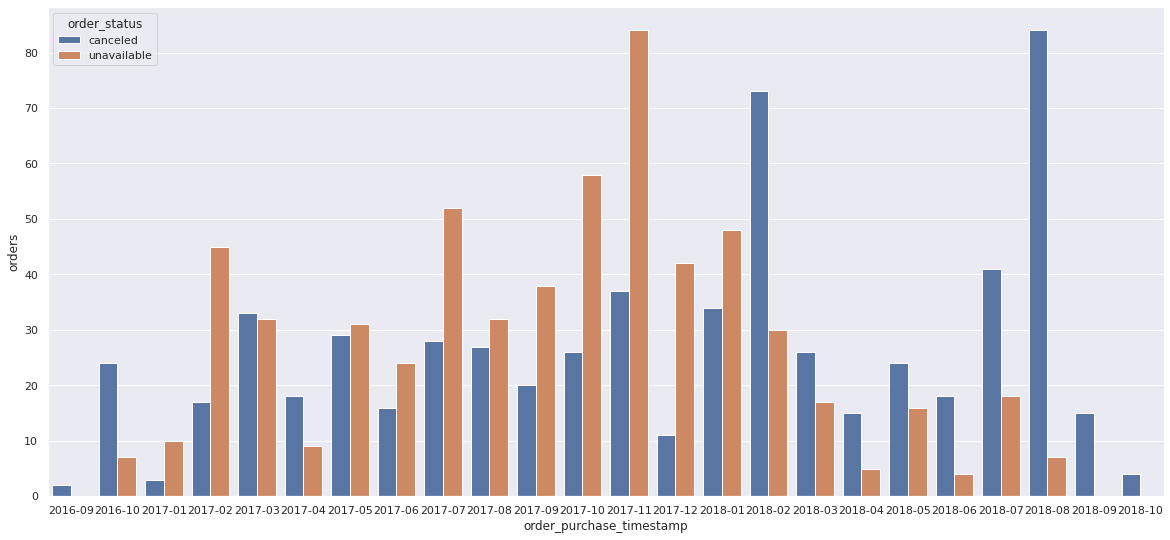

In [135]:
# Для наглядности можем построить график.
sns.set (rc={"figure.figsize": (20, 9)})
sns.barplot(x = undelivered.order_purchase_timestamp, y = undelivered.orders, data = undelivered, hue = undelivered.order_status)

In [136]:
# теперь мы можем посчитать среднее за месяц с разбивкой по статусу заказа.
undelivered.groupby('order_status', as_index = False) \
           .agg({'orders': 'mean'}) \
           .rename(columns = {'orders': 'avg_orders'})

,order_status,avg_orders
0,canceled,26.041667
1,unavailable,29.000000


ДЕЛАЕМ ВЫВОД, ЧТО В СРЕДНЕМ ЗА МЕСЯЦ ЗАКАЗЫ НЕ ДОСТАВЛЯЮТСЯ ПО ПРИЧИНАМ: 1. ОТМЕНЫ ЗАКАЗА 26 ЗАКАЗОВ 2. ЗАКАЗ НЕДОСТУПЕН 29 ЗАКАЗОВ

## 3. По каждому товару определить, в какой день недели товар чаще всего покупается. 

In [26]:
p_orders.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26


In [84]:
orders_items = p_orders.merge(items, how='inner', on=['order_id', 'order_id'])
orders_items.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18,1,87285b34884572647811a353c7ac498a,3504c0cb71d7fa48d967e0e4c94d59d9,2017-10-06 11:07:15,29.99,8.72
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13,1,595fac2a385ac33a80bd5114aec74eb8,289cdb325fb7e7f891c38608bf9e0962,2018-07-30 03:24:27,118.70,22.76
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04,1,aa4383b373c6aca5d8797843e5594415,4869f7a5dfa277a7dca6462dcf3b52b2,2018-08-13 08:55:23,159.90,19.22
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15,1,d0b61bfb1de832b15ba9d266ca96e5b0,66922902710d126a0e7d26b0e3805106,2017-11-23 19:45:59,45.00,27.20
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26,1,65266b2da20d04dbe00c5c2d3bb7859e,2c9e548be18521d1c43cde1c582c6de8,2018-02-19 20:31:37,19.90,8.72


In [85]:
orders_items.order_purchase_timestamp = orders_items.order_purchase_timestamp.dt.day_name()

In [92]:
week_df = orders_items \
    .groupby(["product_id", "order_purchase_timestamp"], as_index=False) \
    .agg({"customer_id": "count"}) \
    .sort_values(by="customer_id", ascending=False) \
    .drop_duplicates(subset='product_id'). rename(columns={'order_purchase_timestamp': 'week_day'})
week_df[{'product_id', 'week_day'}]

,product_id,week_day
15763,422879e10f46682990de24d770e7f83d,Wednesday
36172,99a4788cb24856965c36a24e339b6058,Monday
40673,aca2eb7d00ea1a7b8ebd4e68314663af,Thursday
19940,53b36df67ebb7c41585e8d54d6772e08,Tuesday
13419,389d119b48cf3043d311335e499d9c6b,Thursday
...,...,...
23808,643a4049ae3e6df63858575f28cd7b21,Friday
23810,643a66b1dc5dad3de6cb5a41549e72f1,Sunday
23812,643f86cfb81c8ef89293524c5cd78435,Thursday
23813,64436613065a92eedd50d29d4ec0cd43,Friday


## 4. Сколько у каждого из пользователей в среднем покупок в неделю (по месяцам)? 

In [94]:
df = users_orders.merge(items, how='inner', on=['order_id', 'order_id'])


customer_id                         0
customer_unique_id                  0
customer_zip_code_prefix            0
customer_city                       0
customer_state                      0
order_id                         1567
order_status                     1567
order_purchase_timestamp         1567
order_approved_at                1567
order_delivered_carrier_date     1872
order_delivered_customer_date    2985
order_estimated_delivery_date    1567
dtype: int64

In [96]:
# Превращаем колонку "order_approved_at" в формат год-месяц
df['order_approved_at'] = df["order_approved_at"].dt.to_period("M")

In [97]:
# Сортируем датафрейм: берем только покупки, группируем по времени подтверждения оплаты заказа и уникальному айди клиента.
# Получаем количество покупок по месяцам с разбивкой по уникальному айди клиента
orders_per_month = df.query('order_status == "invoiced" or order_status == "processing" or order_status == "shipped" or order_status == "delivered"') \
                                      .groupby(['order_approved_at','customer_unique_id'], as_index = False) \
                                      .agg({'order_id': 'count'})

In [100]:
# Добавляем колонку с количеством дней в месяце
orders_per_month['days_in_month'] = orders_per_month["order_approved_at"].dt.daysinmonth

In [101]:
# Вычисляем количество недель в месяце и добавляем отдельную колонку
orders_per_month['weeks_in_month'] = (orders_per_month.days_in_month / 7).round(2)

In [102]:
# Зная число покупок за месяц на пользователя, можем в среднем покупок в неделю. Для этого делим количество покупок в месяц
# на количество недель в месяце. 
orders_per_month['week_avg'] = orders_per_month.order_id / orders_per_month.weeks_in_month

In [104]:
orders_per_month.week_avg.reset_index() # week_avg искомая колонка 

,index,week_avg
0,0,0.699301
1,1,0.225734
2,2,0.225734
3,3,0.225734
4,4,0.225734
...,...,...
96535,96535,0.225734
96536,96536,0.225734
96537,96537,0.225734
96538,96538,0.225734


## 5. Когортный анализ пользователей. Определение когорты с самым высоким retention на 3й месяц. 

In [66]:
cohorts_users = users.merge(p_orders, how='left', on=['customer_id', 'customer_id'])
cohorts_users.head()

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,order_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP,00e7ee1b050b8499577073aeb2a297a1,delivered,2017-05-16 15:05:35,2017-05-16 15:22:12,2017-05-23 10:47:57,2017-05-25 10:35:35,2017-06-05
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,9790,sao bernardo do campo,SP,29150127e6685892b6eab3eec79f59c7,delivered,2018-01-12 20:48:24,2018-01-12 20:58:32,2018-01-15 17:14:59,2018-01-29 12:41:19,2018-02-06
2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,1151,sao paulo,SP,b2059ed67ce144a36e2aa97d2c9e9ad2,delivered,2018-05-19 16:07:45,2018-05-20 16:19:10,2018-06-11 14:31:00,2018-06-14 17:58:51,2018-06-13
3,b2b6027bc5c5109e529d4dc6358b12c3,259dac757896d24d7702b9acbbff3f3c,8775,mogi das cruzes,SP,951670f92359f4fe4a63112aa7306eba,delivered,2018-03-13 16:06:38,2018-03-13 17:29:19,2018-03-27 23:22:42,2018-03-28 16:04:25,2018-04-10
4,4f2d8ab171c80ec8364f7c12e35b23ad,345ecd01c38d18a9036ed96c73b8d066,13056,campinas,SP,6b7d50bd145f6fc7f33cebabd7e49d0f,delivered,2018-07-29 09:51:30,2018-07-29 10:10:09,2018-07-30 15:16:00,2018-08-09 20:55:48,2018-08-15


In [67]:
n_orders = cohorts_users.groupby(['customer_unique_id'])['order_id'].nunique()
mult_orders_perc = np.sum(n_orders > 1) / cohorts_users['customer_unique_id'].nunique()
print(f'{100 * mult_orders_perc:.2f}% of customers ordered more than once.')

2.99% of customers ordered more than once.


In [68]:
df = cohorts_users[['customer_unique_id', 'order_id', 'order_purchase_timestamp']].drop_duplicates()
df['order_month'] = df['order_purchase_timestamp'].dt.to_period('M')
df['cohort'] = df.groupby('customer_unique_id')['order_purchase_timestamp'] \
                 .transform('min') \
                 .dt.to_period('M') 

In [69]:
df_cohort = df.groupby(['cohort', 'order_month']) \
              .agg(n_customers=('customer_unique_id', 'nunique')) \
              .reset_index(drop=False)
df_cohort['period_number'] = (df_cohort.order_month - df_cohort.cohort).apply(attrgetter('n'))

In [70]:
cohort_pivot = df_cohort.pivot_table(index = 'cohort',
                                     columns = 'period_number',
                                     values = 'n_customers')

In [71]:
cohort_size = cohort_pivot.iloc[:,0]
retention_matrix = cohort_pivot.divide(cohort_size, axis = 0)
w = df_cohort.merge(cohort_size.reset_index(), how='inner', on=['cohort', 'cohort'])
w['C3'] = w.n_customers / w[0] * 100
w1 = w.query("period_number == 3")
cohort_with_max_retencion = w1[w1['C3'] == w1['C3'].max()]['cohort']
cohort_with_max_retencion

86    2017-05
Name: cohort, dtype: period[M]

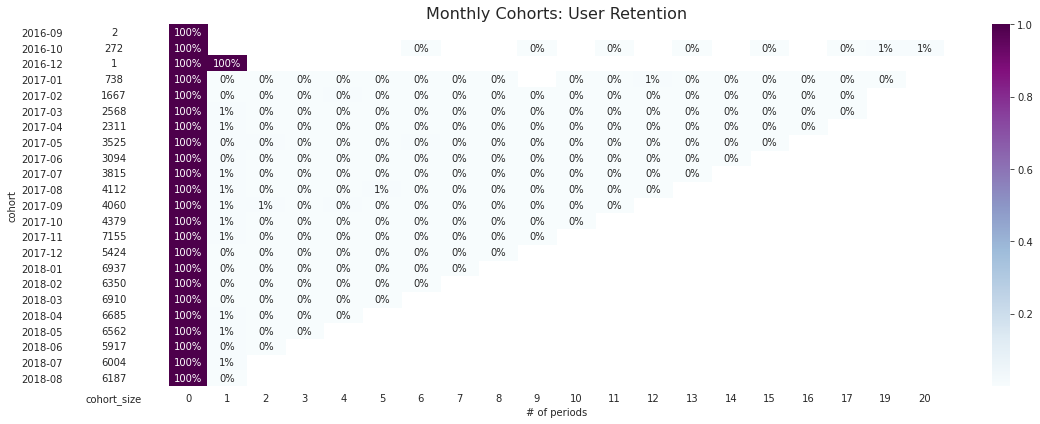

In [72]:
with sns.axes_style("white"):
    fig, ax = plt.subplots(1, 2, figsize=(16, 6), sharey=True, gridspec_kw={'width_ratios': [1, 11]})
    
    # retention matrix
    sns.heatmap(retention_matrix, 
                mask=retention_matrix.isnull(), 
                annot=True, 
                fmt='.0%', 
                cmap='BuPu', 
                ax=ax[1])
    ax[1].set_title('Monthly Cohorts: User Retention', fontsize=16)
    ax[1].set(xlabel='# of periods',
              ylabel='')

    # cohort size
    cohort_size_df = pd.DataFrame(cohort_size).rename(columns={0: 'cohort_size'})
    white_cmap = mcolors.ListedColormap(['white'])
    sns.heatmap(cohort_size_df, 
                annot=True, 
                cbar=False, 
                fmt='g', 
                cmap=white_cmap, 
                ax=ax[0]
                )

    fig.tight_layout()

## 6. RFM-сегментация пользователей


Для RFM показателей будем использовать следующую логику: 

recency — время с момента последней покупки;
frequency — кол-во покупок за все время 
monetary — сумма покупок за все время 

In [139]:
# Отбираем нужные для RFM анализа колонки.
rfm = df.groupby(['customer_unique_id', 'order_id', 'order_purchase_timestamp'], as_index = False) \
               .agg({'price': 'sum'})
# Избавимся от времени в дате.
rfm['order_purchase_timestamp'] = pd.to_datetime(rfm['order_purchase_timestamp']).dt.date

In [118]:
import datetime
today = datetime.date(2018, 9, 3) # задали дату начала анализа (на какой день)

In [119]:
# Создаем RFM таблицу. Для этого группируем по уникальному айди клиента, и агририруем (из Now вы читаем последнюю покупку клиента,
# считаем количество заказов на одного клиента и берем сумму, которую потратил каждый клиент).
RFM_table = rfm.groupby('customer_unique_id', as_index = False)\
    .agg({'order_purchase_timestamp': lambda x: (today - x.max()).days, # Recency
          'order_id'                : lambda x: len(x.unique()),        # Frequency
          'price'                   : lambda x: x.sum()})               # Monetary

In [120]:
# Получаем таблицу с нужными нам данными.Теперь наша задача разделить полученные данные на сегменты.
RFM_table

,customer_unique_id,order_purchase_timestamp,order_id,price
0,0000366f3b9a7992bf8c76cfdf3221e2,116,1,129.90
1,0000b849f77a49e4a4ce2b2a4ca5be3f,119,1,18.90
2,0000f46a3911fa3c0805444483337064,542,1,69.00
3,0000f6ccb0745a6a4b88665a16c9f078,326,1,25.99
4,0004aac84e0df4da2b147fca70cf8255,293,1,180.00
...,...,...,...,...
94669,fffcf5a5ff07b0908bd4e2dbc735a684,452,1,1570.00
94670,fffea47cd6d3cc0a88bd621562a9d061,267,1,64.89
94671,ffff371b4d645b6ecea244b27531430a,573,1,89.90
94672,ffff5962728ec6157033ef9805bacc48,124,1,115.00


In [121]:
# Для удобства переведем колонку с количесвом дней с последней покупки в числовой формат.
RFM_table['order_purchase_timestamp'] = RFM_table['order_purchase_timestamp'].astype(int)

# Переименуем название колонок
RFM_table.rename(columns={'order_purchase_timestamp': 'recency', 
                                      'order_id': 'frequency',
                                      'price': 'monetary'}, inplace=True)

In [122]:
RFM_table.describe()

,recency,frequency,monetary
count,94674.000000,94674.000000,94674.000000
mean,243.103534,1.033790,141.867925
std,152.796608,0.210699,215.722446
min,0.000000,1.000000,0.850000
25%,119.000000,1.000000,47.800000
50%,224.000000,1.000000,89.800000
75%,352.000000,1.000000,154.910000
max,729.000000,16.000000,13440.000000


In [124]:
# Так как метод describe не дает нам понять, как разбиты пользователи по количеству покупок, сделаем соответствующую группировку
RFM_table.groupby('frequency', as_index = False) \
         .agg({'customer_unique_id': 'count'})

,frequency,customer_unique_id
0,1,91803
1,2,2636
2,3,187
3,4,29
4,5,9
5,6,5
6,7,3
7,9,1
8,16,1


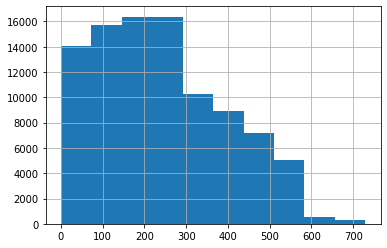

In [125]:
# Для наглядности посмотрим распределение пользователей по дню последней покупки
RFM_table.recency.hist()

Возьмем деление на 3 сегмента т.к. подавляющее большинство пользователей совершило 1 покупку. 
Для принятия решения как мы будем делить каждую метрику на группы, необходимо посмотреть на значения этих кластеров. 
Возьмем разбитие метрик по процентилю с учетом того, что 1 - наихудший показатель, 3 - наилучший показатель:

1. recency (поделим по процентилям 0-25, 25-75 и 75 и далее) 3 - от 0 до 119 дней; 2 - от 120 до 352 дней и 1 - больше 352
2. frequency (будем делить немного подругому, приходится подбирать вручную процентиль) - 3 - от 5 покупок и больше; 2 - 2-4 покупки; 1 - 1 покупка.
3. monetary - (поделим по процентилям 0-25, 25-75 и 75 и далее) 3 - 156 и более, 2 - 48 - 155, 1 - 0 - 47

In [126]:
# Для recency и monetary
quantiles1 = RFM_table.quantile(q=[0.25, 0.75])
quantiles1

,recency,frequency,monetary
0.25,119.0,1.0,47.80
0.75,352.0,1.0,154.91


In [127]:
# Для frequency
quantiles2 = RFM_table.quantile(q=[0.97, 0.9997])
quantiles2

,recency,frequency,monetary
0.9700,548.0,2.0,598.000000
0.9997,699.0,4.0,3118.369381


In [128]:
# Строим 3 разные функции с условиями.
quantiles1
quantiles2
##  RFM Segmentation ----
RFM_Segment = RFM_table.copy()
# Функция для Recency
# Аргументы (x = value, p = recency, monetary, frequency, d = quartiles dict)
def R_Class(x,p,d):
    if x <= d[p][0.25]:
        return 3
    elif x <= d[p][0.75]:
        return 2
    else:
        return 1
    
# Функция для Frequency
# Аргументы (x = value, p = recency, monetary, frequency, d = quartiles dict)
def F_Class(x,p,d):
    if x < d[p][0.97]:
        return 1
    elif x <= d[p][0.9997]:
        return 2
    else:
        return 3

# Функция для Monetary    
# Аргументы (x = value, p = recency, monetary, frequency, d = quartiles dict)
def M_Class(x,p,d):
    if x <= d[p][0.25]:
        return 1
    elif x <= d[p][0.75]:
        return 2
    else:
        return 3

# Добавляем в датафрейм новые строки
RFM_Segment['R_seg'] = RFM_Segment['recency'].apply(R_Class, args=('recency',quantiles1,))
RFM_Segment['F_seg'] = RFM_Segment['frequency'].apply(F_Class, args=('frequency',quantiles2,))
RFM_Segment['M_seg'] = RFM_Segment['monetary'].apply(M_Class, args=('monetary',quantiles1,))
RFM_Segment['RFMClass'] = RFM_Segment.R_seg.map(str) \
                        + RFM_Segment.F_seg.map(str) \
                        + RFM_Segment.M_seg.map(str)

In [129]:
RFM_Segment

,customer_unique_id,recency,frequency,monetary,R_seg,F_seg,M_seg,RFMClass
0,0000366f3b9a7992bf8c76cfdf3221e2,116,1,129.90,3,1,2,312
1,0000b849f77a49e4a4ce2b2a4ca5be3f,119,1,18.90,3,1,1,311
2,0000f46a3911fa3c0805444483337064,542,1,69.00,1,1,2,112
3,0000f6ccb0745a6a4b88665a16c9f078,326,1,25.99,2,1,1,211
4,0004aac84e0df4da2b147fca70cf8255,293,1,180.00,2,1,3,213
...,...,...,...,...,...,...,...,...
94669,fffcf5a5ff07b0908bd4e2dbc735a684,452,1,1570.00,1,1,3,113
94670,fffea47cd6d3cc0a88bd621562a9d061,267,1,64.89,2,1,2,212
94671,ffff371b4d645b6ecea244b27531430a,573,1,89.90,1,1,2,112
94672,ffff5962728ec6157033ef9805bacc48,124,1,115.00,2,1,2,212


In [130]:
# Для наглядности отберем топ 5 пользьзователей в нашей сегментации.
RFM_Segment[RFM_Segment['RFMClass']=='333'].sort_values('monetary', ascending=False).head()

,customer_unique_id,recency,frequency,monetary,R_seg,F_seg,M_seg,RFMClass
94121,fe81bb32c243a86b2f86fbf053fe6140,74,5,1535.40,3,3,3,333
74967,ca77025e7201e3b30c44b472ff346268,94,7,806.61,3,3,3,333
52182,8d50f5eadf50201ccdcedfb9e2ac8455,14,16,729.62,3,3,3,333
81665,dc813062e0fc23409cd255f7f53c7074,11,6,687.76,3,3,3,333
37253,6469f99c1f9dfae7733b25662e7f1782,67,7,664.20,3,3,3,333
